In [1]:
import pandas as pd
import numpy as np
import json
import re
import glob
from pathlib import Path

# 2007-05-15 15:52:27	
#"content": "\nExecutives"
# lamma resulted in values, maybe bais from trainig data


In [92]:
prompt = "FIVE_SCORING"
from constants import MODELS

with open('data/profiles.json') as f:
    profiles = json.load(f)

spy_prices = pd.read_csv("data/SPY.csv", index_col=0, parse_dates=True)

# from corr output for each matrix row select the first element
def calc_beta(stock,windows_days = 5*252):
    temp_df = spy_prices.join(stock,lsuffix='_spy', rsuffix='_stock')[['open_spy','open_stock']].sort_index().pct_change().copy()
    cov = temp_df.rolling(windows_days).cov().unstack().iloc[:,1]
    var = temp_df[['open_spy']].rolling(windows_days).var().iloc[:,0]
    return (cov/var)

stocks_predictions = {}
prices = {}



# go though models
for symbol, info in profiles.items():
    model_texts = []
    # load prices
    prices[symbol] = pd.read_csv(f"data/{symbol}/historical.csv", index_col=0, parse_dates=True)
    prices[symbol]['beta'] = calc_beta(prices[symbol])
    prices[symbol] = prices[symbol].dropna()

    for model, model_folder_name in MODELS.items():
        path = f"data/{symbol}/{prompt}/{model_folder_name}"
        # get all txt files in the folder
        files = glob.glob(path + "/*.txt")
        files_as_index = [Path(file).stem for file in files]
        # read all to pandas columns and index will be the filename
        # files have text only
        texts = []
        for file in files:
            with open(file) as f:
                texts.append(f.read())
        model_texts.append(
            pd.Series(
                texts,
                name=model,
                index=pd.to_datetime(files_as_index),
                dtype=str
            )
        )
    stocks_predictions[symbol] = pd.concat(model_texts, axis=1)
        
stocks_predictions_numbers = {}
for symbol, df in stocks_predictions.items():
    stocks_predictions_numbers[symbol] = df.apply(lambda x: x.str.findall(r'(-2|-1|0|1|2)').str[-1])
        


In [143]:
def convert_to_price_series(stock, additional_columns = ['beta']):

    opens = stock[['open'] + additional_columns].rename({'open':'price'},axis=1).copy()
    closes = stock[['close'] + additional_columns].rename({'close':'price'},axis=1).copy()
    opens.index += pd.Timedelta(hours=9, minutes=30)
    closes.index += pd.Timedelta(hours=16, minutes=0)

    return pd.concat([opens,closes],axis=0).sort_index()
convert_to_price_series(spy_prices,additional_columns=[])

,price
date,
2000-01-03 09:30:00,148.25
2000-01-03 16:00:00,145.44
2000-01-04 09:30:00,143.53
2000-01-04 16:00:00,139.75
2000-01-05 09:30:00,139.94
...,...
2025-01-06 16:00:00,595.36
2025-01-07 09:30:00,597.42
2025-01-07 16:00:00,588.63


In [282]:
model = "perplexity/llama-3.1-sonar-large-128k-online"
stock_pred = stocks_predictions_numbers[symbol]
print(symbol)
stock_pred_model = stock_pred[[model]].copy()
stock_pred_model.head(10)

WMT


,perplexity/llama-3.1-sonar-large-128k-online
2006-02-21 11:09:38,1
2007-02-20 13:33:20,2
2006-11-14 11:41:26,0
2006-08-15 12:25:09,0
2006-05-16 11:11:27,1
2008-02-19 12:52:08,1
2007-11-13 12:27:04,1
2007-08-14 15:03:22,-1
2007-05-15 15:52:27,2
2008-11-13 13:15:30,1


,openai/gpt-4o,direction
2006-02-21 11:09:38,1,1.0
2006-05-16 11:11:27,1,1.0
2006-08-15 12:25:09,0,0.0
2006-11-14 11:41:26,0,0.0
2007-02-20 13:33:20,1,1.0
...,...,...
2023-11-16 13:13:13,1,1.0
2024-02-20 11:58:09,1,1.0
2024-05-16 10:55:31,1,1.0
2024-08-15 10:37:07,1,1.0


2006-02-21 11:09:38    1.0
2006-05-16 11:11:27    1.0
2007-02-20 13:33:20    1.0
2007-08-14 15:03:22   -1.0
2007-11-13 12:27:04    1.0
2008-02-19 12:52:08    1.0
2008-05-14 12:07:09    1.0
2008-08-14 13:55:22    1.0
2008-11-13 13:15:30    1.0
2009-08-13 15:10:57    1.0
2009-11-12 15:33:08    1.0
2010-02-18 13:45:18    1.0
2010-11-18 17:00:00    1.0
2011-02-22 18:10:15   -1.0
2011-05-23 22:10:14    1.0
2011-08-16 12:00:15    1.0
2011-11-15 12:10:55    1.0
2012-02-21 13:50:03    1.0
2012-05-16 00:00:00    1.0
2012-08-15 00:00:00    1.0
2012-11-14 00:00:00    1.0
2013-02-20 00:00:00    1.0
2013-08-15 08:55:04   -1.0
2015-05-19 11:27:09    1.0
2015-08-18 15:58:05   -1.0
2015-11-17 12:54:14    1.0
2016-02-18 12:41:08    1.0
2016-05-19 09:26:53    1.0
2016-08-18 12:12:57    1.0
2016-11-17 09:58:18    1.0
2017-02-20 00:00:00    1.0
2017-05-18 08:15:47    1.0
2017-08-17 08:41:04    1.0
2017-11-16 09:25:42    1.0
2018-02-20 13:00:07    1.0
2020-02-18 00:00:00    1.0
2020-05-19 00:00:00    1.0
2

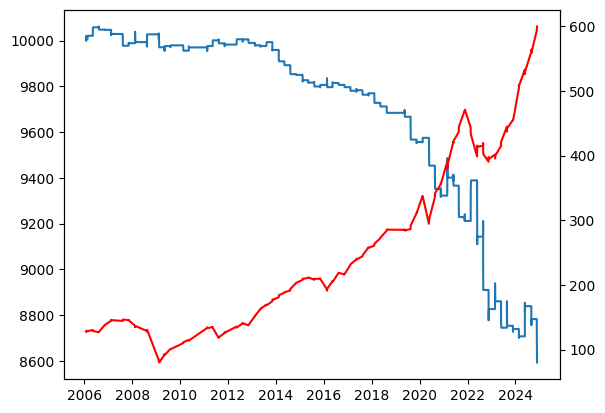

In [396]:
def backtest(stock_prices,spy_prices, stock_pred, timeframe, sizing_strategy,current_pos=10000):
    spy_series = convert_to_price_series(spy_prices,additional_columns=[])
    stock_series = convert_to_price_series(stock_prices,additional_columns=['beta'])




    series = stock_series.join(spy_series,lsuffix='_stock',rsuffix='_spy')
    stock_pred = stock_pred[stock_pred.index >= series.index[0]].copy()


    enter_idx = series.index.searchsorted(stock_pred.index)
    leave_idx = series.index.searchsorted(stock_pred.index + timeframe)
    idx_size = enter_idx.size

    # can not trade on the same time
    leave_idx[leave_idx == enter_idx] += 1



    output = []
    open_idx = None
    trade_id = 0
    shares = None
    direction = None
    idx = 0
    event = None
    for date, row in series.iterrows():
        #print(trade_id)
        if trade_id < idx_size and idx == enter_idx[trade_id]:
            assert open_idx is None
            open_idx = idx
            event = "opening"
            direction = stock_pred.iloc[trade_id]['direction']
            shares = sizing_strategy(current_pos, row['price_stock'], row['price_spy'], row['beta'])
            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos,
                0,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])

        elif trade_id < idx_size and idx == leave_idx[trade_id]:
            assert open_idx is not None
            change = direction*shares*(row['price_stock'] - series.iloc[open_idx]['price_stock'] - series.iloc[open_idx]['beta']* (row['price_spy'] - series.iloc[open_idx]['price_spy']))
            current_pos += change
            event = "closing"

            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos,
                change,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])




            open_idx = None
            shares = None
            direction = None
            trade_id += 1
            
            # close position
        elif open_idx is not None:
            event = "holding"
            change = direction*shares*(row['price_stock'] - series.iloc[open_idx]['price_stock'] - series.iloc[open_idx]['beta']* (row['price_spy'] - series.iloc[open_idx]['price_spy']))

            output.append([
                date,
                trade_id,
                idx,
                event,
                current_pos + change,
                change,
                direction,
                stock_pred.iloc[trade_id][model],
                shares,
                row['price_stock'],
                row['price_spy'],
                row['beta'],
            ])



            pass
            # we have in the middle of open position
        else:
            event = "waiting"

        idx+=1

    output = pd.DataFrame(output,columns=['date','trade_id','idx','event','current_pos','change','direction','score','shares','price_stock','price_spy','beta']).set_index('date')
    # find index of wirst current_pos < 0
    first_neg = output['current_pos'] < 0
    if first_neg.any():
        output = output.loc[:output[first_neg].index[0]].copy()

    # calculate metrics

    
    return output



symbol="NVDA"

# add filter by strategy
stock_pred = stocks_predictions_numbers[symbol]
# filter by model
model = "openai/gpt-4o"
stock_pred = stock_pred[[model]].copy()
# direction is just sign of the number


# drop zeros
stock_pred['direction'] = stock_pred[model].dropna().astype(int).map({
    -2: -1,
    -1: -1,
    0: np.nan,
    1: 1,
    2: 1
})
# filter nans
stock_pred = stock_pred.sort_index().dropna()
#display(stock_pred)

# different timeframes
timeframe = pd.Timedelta(days=3)

def sizing_strategy(current_pos, price_stock, price_spy, beta):
    return 10#current_pos/price_stock


output = backtest(prices[symbol],spy_prices, stock_pred, timeframe, sizing_strategy,current_pos=10000)



to_plot = output#.iloc[:9]
# plot current_pos
# plot price_stock on separate y axis

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(to_plot.index, to_plot['current_pos'])
ax2 = ax1.twinx() 

ax2.plot(to_plot.index, to_plot['price_spy'],color='red')
plt.show()

